<h3> Imports </h3> 

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt 
import numpy as np 
from math import log
import json 
import time
from random import randint

# keras imports for neural network
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras import optimizers

c:\users\mrinal\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<h2> Data Preparation for training and testing </h2>

I see two datasets available in the task: <br>
One seems to be from 2016, without currency conversion to USD. <br> 
Another is from 2018 with some newly added records

In [2]:
kick_start_2016 = pd.read_csv('inputs/ks-projects-201612.csv', encoding = 'ISO-8859-1')
kick_start_2016.head()

c:\users\mrinal\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN


In [3]:
kick_start_2018 = pd.read_csv('inputs/ks-projects-201801.csv')
kick_start_2018.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [4]:
print(len(kick_start_2018) - len(kick_start_2016))

54911


<h3> So, there are 54911 more records in 2018 data than 2016 data </h3> 

<h3>These records may be ideal for testing. </h3> <br> 
I will now extract only those records from 2018 data that also exist in 2016 using the ID field.<br>
But first, the 2016 data needs renaming the columns labels (removing trailing spaces etc.) to bring it to the same format as 2018 data.

In [5]:
kick_start_2016.columns

Index(['ID ', 'name ', 'category ', 'main_category ', 'currency ', 'deadline ',
       'goal ', 'launched ', 'pledged ', 'state ', 'backers ', 'country ',
       'usd pledged ', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16'],
      dtype='object')

In [6]:
kick_start_2018.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

In [7]:
# renaming the 2016 data columns
kick_start_2016.columns = ['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd_pledged', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16']

<h3> Extracting what is common to both datasets, in 2018 data. <br>
This will be used to train the decision tree and the neural network. <br>
I have mentioned how to combine both these models for both training and testing in the overall strategy further below.<h3>

In [8]:
kick_start_common = kick_start_2018.loc[kick_start_2018.ID.isin(kick_start_2016.ID)].reset_index(drop=True)
len(kick_start_common)

323750

In [9]:
kick_start_common.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00


<h3> Extracting records unique to 2018 data </h3>
<h3> I will use these as my test dataset later towards the end to get the final accuracy of the combined model. 

In [10]:
kick_start_unique = kick_start_2018.loc[-kick_start_2018.ID.isin(kick_start_2016.ID)].reset_index(drop=True)
len(kick_start_unique)

54911

In [11]:
kick_start_unique.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
1,1000057089,Tombstone: Old West tabletop game and miniatur...,Tabletop Games,Games,GBP,2017-05-03,5000.0,2017-04-05 19:44:18,94175.00,successful,761,GB,57763.78,121857.33,6469.73
2,1000081649,MikeyJ clothing brand fundraiser,Childrenswear,Fashion,AUD,2017-09-07,2500.0,2017-08-08 01:20:20,1.00,failed,1,AU,0.00,0.81,2026.10
3,100011318,My Moon - Animated Short Film,Animation,Film & Video,USD,2017-05-03,50000.0,2017-04-03 17:11:33,57577.31,successful,840,US,10120.00,57577.31,50000.00
4,1000149007,Unschooling To University Book Project,Nonfiction,Publishing,CAD,2018-01-19,3000.0,2017-11-20 18:15:14,592.00,live,24,CA,185.65,472.88,2396.36


<h2> Lets focus on the training dataset for now and visualize some of its aspects. </h2>

In [12]:
kick_start = kick_start_common

In [13]:
kick_start["state"].unique()

array(['failed', 'canceled', 'successful', 'undefined', 'suspended',
       'live'], dtype=object)

<b> Checking the distribution of the target field </b> 

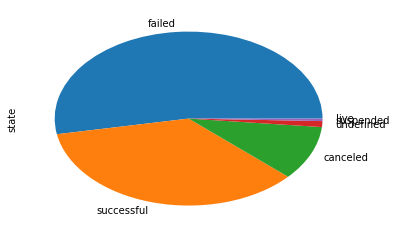

In [14]:
pd.value_counts(kick_start['state']).plot.pie()

<h3> Analyses, assumptions and visualizations </h3> 

<b>My first assumption is that the "state" will correlate well with the number of days between "launch" and "deadline".</b> <br>
So, I convert those dates and bring them to "No. of days" format.

In [15]:
x = pd.to_datetime(kick_start["deadline"])
y = pd.to_datetime(kick_start["launched"])
z = x - y  

print (z.min())
print (z.mean())
print (z.max())

0 days 00:07:17
34 days 04:46:57.291894
16738 days 23:00:00


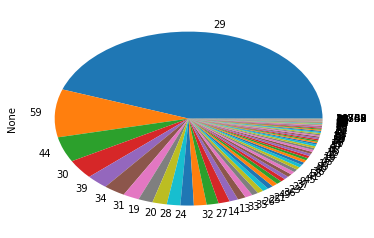

In [16]:
num_days = z.apply(lambda x: str(x.days))
pd.value_counts(num_days).plot.pie()

<b> Most projects seem to have a deadline of 29 days (~1 month), followed by 59 days (~2 months) etc. </b> 

<h3> Overall strategy for training</h3>

I will select certain fields (mostly categorical) to feed to a Decision Tree model to reduce entropy in the data. This will  also include the "No. of days to deadline" computed above. 

If the decision tree returns some good results and is able to reduce entropy by looking at just the categorical data (<b>without the $amounts, backers etc. </b>), I will get the probability distribution of states as the "partial" predictions from this tree. 

Next, I will concatenate these partial predictions with the rest of the columns ($amounts, backers etc.) to create a "feature vector". <br>
This feature vector would then go as inputs to a neural network for further training. <br>

So, even while testing, predictions will be broken down to two parts, first to recieve partial predictions from the decision tree and then to get the final predictions from the neural network.

<b> The intuition is to use the Decision Tree to handle entropy in the categorical data and reduce the non-linearity / dimensions for the neural network to achieve better learning. </b>

Since I need the probability distributions from the decision tree, I am implementing a decision tree based on[ ID3 algorithm ](https://en.wikipedia.org/wiki/ID3_algorithm)for this purpose. 

<h3> Fields selected for decision tree : </h3> 

<ul> 
    <li> category </li>
    <li> main_category </li>
    <li> currency </li>
    <li> country </li> 
    <li> Number of days to deadline </li> 
</ul> 

<b> The "id" and "name" fields will be omitted as I don't think there is much correlation between these fields and the "state" </b> 
    

In [17]:
dt_kstart = kick_start[['category', 'main_category', 'currency', 'country', 'state']]
dt_kstart['num_days'] = num_days

c:\users\mrinal\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
dt_kstart.state.value_counts()

failed        171203
successful    114789
canceled       32702
undefined       3562
suspended       1492
live               2
Name: state, dtype: int64

In [19]:
# this function calculates the probability distribution of the unique items for a specified column in a dataframe
def get_probabilities(df, column):
    freqs = df[column].value_counts()
    summation = sum(freqs)
    probabilities = freqs / summation
    return (probabilities) 

# function to return log base 2
def ln(x):
    return log(x)/log(2)

# to return the entropy given the probability distribution    
def get_entropy(probabilities):
    return sum(probabilities * probabilities.apply(ln)) * -1       # Claude Elwood Shannon

In [20]:
# Initial entropy of the 'state' column in the training data
get_entropy(get_probabilities(dt_kstart, 'state'))

1.4579962179445682

In [21]:
dt_kstart.head()

,category,main_category,currency,country,state,num_days
0,Poetry,Publishing,GBP,GB,failed,58
1,Narrative Film,Film & Video,USD,US,failed,44
2,Music,Music,USD,US,failed,29
3,Film & Video,Film & Video,USD,US,canceled,55
4,Restaurants,Food,USD,US,successful,34


In [22]:
# splitting a data-frame, on an index/column and value 
# returns the new dataframe after the split
def split_data(df, column, value):
    return df[df[column] == value]

# to get the best feature based on information gain 
def get_best_feature(df, target, to_print=False):
    initial_entropy = get_entropy(get_probabilities(df, target))
    best_gain = 0.0
    best_feature = None
    feature_list = list(df.columns)
    feature_list.remove(target)
    for feature in feature_list:
        uniques = df[feature].unique()
        new_entropy = 0 
        for value in uniques:
            subset =  split_data (df, feature, value) 
            probability = len(subset) / len(df)
            new_entropy += probability * get_entropy(get_probabilities(subset, target))
        info_gain = initial_entropy - new_entropy
        if to_print:
            print (info_gain, feature)
        if info_gain > best_gain:
            best_gain = info_gain
            best_feature = feature
            
    return best_feature

In [23]:
get_best_feature(dt_kstart, 'state', True)

0.11642136016126248 category
0.0567531938487531 main_category
0.0072016819468441184 currency
0.09063503898205139 country
0.02998172295675361 num_days


'category'

<h2>  Looks like, my assumption that num_days would highly correlate with state, is wrong! </h2> 

Nonetheless, there is some correlation and some information gain. <br>
We now proceed to build the Decision Tree <br>
Though the output of this decision tree is a probability distribution, I still label it as 'state' so that it is easier to retreive predictions from this tree later. 

In [24]:
# returns true if there is only one label in the target field 
def is_pure(df, target):
    return len(df[target].unique()) == 1
        
def create_tree(df, target):
    # condition for pure data (when there is only one possible 'state')
    if is_pure(df, target):
        return {'state' : dict(get_probabilities(df, target))}
    
    # condition for leaf nodes
    if len(df.columns) <= 2:
        features = list(df.columns)
        features.remove(target)
        feature = features[0]
        leaf_node = {feature:{}}
        uniques = df[feature].unique()
        for value in uniques:
            subset = split_data(df, feature, value)
            leaf_node[feature][value] = {'state' : dict(get_probabilities(subset, target))}
        return leaf_node
    
    # recursive call to create the nested tree/dictionary
    best_feature = get_best_feature(df, target)
    if best_feature:
        my_tree = {best_feature:{}}
        uniques = df[best_feature].unique()
        for value in uniques:
            subset = split_data(df, best_feature, value)
            subset = subset.drop(best_feature, axis=1)
            my_tree[best_feature][value] = create_tree(subset, target)
    else: 
        my_tree = {'state' : dict(get_probabilities(df, target))}
        
    return my_tree
            

In [25]:
# start time
start = time.perf_counter()

# creating the tree
d_tree = create_tree(dt_kstart, 'state')

# saving the dictionary
filename = 'decision_tree.txt'
with open(filename, 'w') as f:
    json.dump(d_tree, f)
    
# end time
stop = time.perf_counter()

print('Creating the Decision Tree took close to ' + str((stop-start)/60.0) + ' minutes')

Creating the Decision Tree took close to 3.3923719378828547 minutes


In [26]:
# loading the tree
def load_tree(filename):
    with open(filename, 'r') as f:
        return json.load(f)

d_tree = load_tree('decision_tree.txt')

In [27]:
# to predict a single instance of a feature using the decision tree
# inputs: the tree; an instance of features of type pandas.Series.series
# returns: the probability distribution of the states as a dictionary
def partial_predict(tree, features):
    probabs = {}
    first_dict = next(iter(tree))
    second_dict = tree[first_dict]
    feat_value = features[first_dict]
    if first_dict != 'state':
        for key in second_dict.keys():
            if feat_value == key:
                probabs = partial_predict(second_dict[key], features)
    else: 
        probabs = second_dict
    return probabs

<h3> Unit testing the tree on a single instance/row </h3>

In [28]:
labels = dict(dt_kstart.loc[89])
labels

{'category': 'Restaurants',
 'country': 'US',
 'currency': 'USD',
 'main_category': 'Food',
 'num_days': '59',
 'state': 'failed'}

In [29]:
partial_predict(d_tree, labels)

{'canceled': 0.1394422310756972,
 'failed': 0.8127490039840638,
 'successful': 0.043824701195219126,
 'suspended': 0.00398406374501992}

In [30]:
# retrieving data from the tree
d_tree['category']['Restaurants']['num_days']['59']['country']['US']

{'state': {'canceled': 0.1394422310756972,
  'failed': 0.8127490039840638,
  'successful': 0.043824701195219126,
  'suspended': 0.00398406374501992}}

<h3> Translate probability distributions from a dictionary to a numpy array </h3>

In [31]:
# to translate a predicted distribution (a dictionary) to its corresponding numpy version
def translate(distribution):
    array = np.zeros([6])
    # to hardcode positions in the numpy array 
    positions = {'failed':0, 
                 'successful':1, 
                 'canceled':2, 
                 'undefined':3, 
                 'live':4, 
                 'suspended':5} 
    for key in positions:
        if key in distribution.keys():
            array[positions[key]] = distribution[key]
    return array

In [32]:
x = partial_predict(d_tree, labels) #same example as above
print(x)
y = translate(x)
print (y) # this is now translated to a numpy version

{'failed': 0.8127490039840638, 'canceled': 0.1394422310756972, 'successful': 0.043824701195219126, 'suspended': 0.00398406374501992}
[0.812749   0.0438247  0.13944223 0.         0.         0.00398406]


In [33]:
# since this is a probability distribution, all entries must sum to 1 
y.sum()

1.0

<h3> Generating probability distributions from categorical data for the entire training dataset using the tree </h3>

In [34]:
to_predict = dt_kstart

In [35]:
# to get predictions for an entire dataframe
def get_partial_predictions(tree, inputs):
    partial_predictions = []
    for index,row in inputs.iterrows():
        features = dict(row)
        probabs = partial_predict(tree, features)
        arr = translate(probabs)
        partial_predictions.append(arr)
    return np.array(partial_predictions)

In [36]:
start = time.perf_counter()
part_predict = get_partial_predictions(d_tree, to_predict)
stop = time.perf_counter()

print(part_predict.shape)
print('This process took ' + str(stop-start) + ' seconds')

(323750, 6)
This process took 53.99899200082706 seconds


 <h2> 'part_predict' now contains the partial predictions from the decision tree for the entire dataset </h2>

<h2> Preparing training dataset for the neural network </h2> 

As was mentioned earlier, the neural network needs the probability distributions from the tree and the remaining numerical columns. 

So the inputs to the neural net. would be: 

<ul>
    <li> Probability Distributions from the decision tree (length = 6) </li>
    <li> backers </li>
    <li> usd_pledged_real </li>
    <li> usd_goal_real </li> 
</ul> 

I am omitting the other columns for "pledged" and "goal" as they may contain different 'currencies' which has already been handled by the tree.  

<h2> Concatenate the partial prediction to the remaining (numeric) fields in the dataset </h2> 

In [37]:
nn_train_part1 = part_predict
nn_train_part2 = np.array(kick_start[['backers', 'usd_pledged_real', 'usd_goal_real']])

print (nn_train_part1.shape)
print (nn_train_part2.shape)

(323750, 6)
(323750, 3)


In [38]:
nn_inputs = np.concatenate((nn_train_part1, nn_train_part2), axis=1)
print(nn_inputs.shape)

(323750, 9)


In [39]:
# save the training_inputs for the neural network
np.save('nn_inputs', nn_inputs)

In [40]:
# for the targets of the neural network
states = np.array(kick_start['state'])
states.shape

(323750,)

In [41]:
# to translate the state into integers for one-hot encoding
def translate_states(states):
    array = np.empty([len(states)], dtype = 'int8')
    positions = {'failed':0, 
                 'successful':1, 
                 'canceled':2, 
                 'undefined':3, 
                 'live':4, 
                 'suspended':5} 
    for i, state in enumerate(list(states)):
        array[i] = int(positions[state])
    return array

In [42]:
translated = translate_states(states)
translated[:10]

array([0, 0, 0, 2, 1, 1, 0, 2, 2, 0], dtype=int8)

In [43]:
# One hot encoding
nb_classes = 6
one_hot_targets = np.eye(nb_classes)[translated]

In [44]:
one_hot_targets[:10]

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [45]:
# saving the targets for the neural network
np.save('one_hot_targets', one_hot_targets)

<h2> We now have our inputs in "nn_inputs" and our targets in "one_hot_targets". </h2>

<b> Training the Neural Network </b> 

In [46]:
inputs = np.load('nn_inputs.npy')
targets = np.load('one_hot_targets.npy')

In [47]:
model = Sequential()
model.add(Dense(9, input_dim=9, activation='sigmoid'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(15, activation='sigmoid'))
model.add(Dense(10, activation='sigmoid'))
model.add(Dense(6, activation = 'softmax')) 

model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

model.fit(nn_inputs, one_hot_targets, validation_split = 0.1, epochs = 6, batch_size=120)

Train on 291375 samples, validate on 32375 samples
Epoch 1/6
291375/291375 [==============================] - 27s 93us/step - loss: 0.1378 - acc: 0.9529 - val_loss: 0.1213 - val_acc: 0.9604
Epoch 2/6
291375/291375 [==============================] - 19s 64us/step - loss: 0.1188 - acc: 0.9609 - val_loss: 0.1182 - val_acc: 0.9610
Epoch 3/6
291375/291375 [==============================] - 17s 60us/step - loss: 0.1186 - acc: 0.9609 - val_loss: 0.1185 - val_acc: 0.9609
Epoch 4/6
291375/291375 [==============================] - 16s 55us/step - loss: 0.1185 - acc: 0.9609 - val_loss: 0.1187 - val_acc: 0.9609
Epoch 5/6
291375/291375 [==============================] - 19s 66us/step - loss: 0.1182 - acc: 0.9610 - val_loss: 0.1184 - val_acc: 0.9609
Epoch 6/6
291375/291375 [==============================] - 17s 57us/step - loss: 0.1177 - acc: 0.9611 - val_loss: 0.1184 - val_acc: 0.9610


In [48]:
model.save('nn_model.h5')

In [49]:
# helper function to convert dates to num_days
def convert_dates(features):
    x = pd.to_datetime(features["deadline"])
    y = pd.to_datetime(features["launched"])
    z = x - y 
    num_days = str(z.days)
    return num_days
    
# for final predictions using both the decision tree and the neural network 
# inputs: a pandas.Series.series object called features, and,
#         the trained decision tree and neural network
# outputs: the predicted 'state' for the provided features as a numpy array 
def predict(features, d_tree, model):
    expected_out = one_hot = None
    reverse_hot = {0:'failed', 
                   1:'successful', 
                   2:'canceled', 
                   3:'undefined', 
                   4:'live', 
                   5:'suspended'}
    num_days = convert_dates(features)
    features = dict(features)
    features['num_days'] = num_days
    part_preds = partial_predict(d_tree, features)
    part1 = translate(part_preds)
    part2 = np.array([features['backers'], 
                      features['usd_pledged_real'], 
                      features['usd_goal_real']])
    to_predict = np.concatenate((part1, part2))
    to_predict = np.array([to_predict])
    predicted_numpy = model.predict(to_predict)
    prediction = np.array(reverse_hot[predicted_numpy.argmax()])
    return prediction

<h3> Testing on some instances </h3>

In [50]:
# test an i'th row in the dataset
def get_prediction(i):
    return predict(kick_start.loc[i], d_tree, model)

print (get_prediction(randint(0,1000)))
print (get_prediction(randint(0,5000)))
print (get_prediction(randint(0,1000)))
print (get_prediction(randint(0,5000)))

failed
failed
successful
successful


<h2> Testing with the entire training dataset </h2> 

Loading the models

In [51]:
model = load_model('nn_model.h5')
d_tree = load_tree('decision_tree.txt')

<h3> Droping the 'state' labels from the test data and filling it with 'None' </h3> 

In [52]:
kick_start_test = kick_start.drop(['state'], axis=1)
kick_start_test['state'] = None

In [53]:
kick_start_test.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,backers,country,usd pledged,usd_pledged_real,usd_goal_real,state
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,GB,0.0,0.0,1533.95,None
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,3,US,220.0,220.0,45000.00,None
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,1,US,1.0,1.0,5000.00,None
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,14,US,1283.0,1283.0,19500.00,None
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,224,US,52375.0,52375.0,50000.00,None


In [54]:
expected_outputs = kick_start['state']
expected_outputs[:10]

0        failed
1        failed
2        failed
3      canceled
4    successful
5    successful
6        failed
7      canceled
8      canceled
9        failed
Name: state, dtype: object

In [55]:
start = time.perf_counter()

results = {'predicted':[], 'expected': list(expected_outputs)}
for index,row in kick_start_test.iterrows():
    results['predicted'].append(predict(row, d_tree, model))  

end = time.perf_counter()
print ('Getting predictions on the training dataset took ' + 
       str((end - start) / 60.0) + ' minutes')

Getting predictions on the training dataset took 10.777156134982999 minutes


In [56]:
results_df = pd.DataFrame(results)
results_df.to_csv('results_training_data.csv')

In [57]:
def display_results_data(result_df):
    matches = result_df.loc[(result_df['predicted'] == result_df['expected'])]
    match_percentage = len(matches)/len(result_df) * 100
    errors =  result_df.loc[(result_df['predicted'] != result_df['expected'])]
    error_percentage = len(errors)/len(result_df) * 100
    
    print ('\nTrue Positives = ' + str(len(matches)) + 
           '\t\t' + 'True Pos. Percentage = ' + 
           str(match_percentage))
    print ('\nErrors = ' + str(len(errors)) +
           '\t\t\t' + 'Error Percentage = ' + 
           str(error_percentage))


In [58]:
display_results_data(results_df)


True Positives = 285939		True Pos. Percentage = 88.32092664092664

Errors = 37811			Error Percentage = 11.67907335907336


<h1> TESTING ON UNSEEN DATA </h1> 
<h3> Loading the models </h3>

In [59]:
model = load_model('nn_model.h5')
d_tree = load_tree('decision_tree.txt')

<h3> I will now use the 'kick_start_unique' dataframe. <br>
This dataframe was set aside for testing. <br>
It contains the unique data from the 2018 file that are not present in 2016 file. <br>
These records are "new" to both the models as only 2016 records were considered for their training.</h3>

In [60]:
kick_start_unique.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
1,1000057089,Tombstone: Old West tabletop game and miniatur...,Tabletop Games,Games,GBP,2017-05-03,5000.0,2017-04-05 19:44:18,94175.00,successful,761,GB,57763.78,121857.33,6469.73
2,1000081649,MikeyJ clothing brand fundraiser,Childrenswear,Fashion,AUD,2017-09-07,2500.0,2017-08-08 01:20:20,1.00,failed,1,AU,0.00,0.81,2026.10
3,100011318,My Moon - Animated Short Film,Animation,Film & Video,USD,2017-05-03,50000.0,2017-04-03 17:11:33,57577.31,successful,840,US,10120.00,57577.31,50000.00
4,1000149007,Unschooling To University Book Project,Nonfiction,Publishing,CAD,2018-01-19,3000.0,2017-11-20 18:15:14,592.00,live,24,CA,185.65,472.88,2396.36


 Initializing the "expected" outputs and dropping the 'state' column from test_data

In [61]:
expected_outputs = kick_start_unique['state']
expected_outputs[:10]

0        failed
1    successful
2        failed
3    successful
4          live
5    successful
6        failed
7        failed
8        failed
9    successful
Name: state, dtype: object

In [62]:
test_data = kick_start_unique.drop(['state'], axis=1)
test_data['state'] = None
test_data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,backers,country,usd pledged,usd_pledged_real,usd_goal_real,state
0,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,15,US,100.00,2421.00,30000.00,None
1,1000057089,Tombstone: Old West tabletop game and miniatur...,Tabletop Games,Games,GBP,2017-05-03,5000.0,2017-04-05 19:44:18,94175.00,761,GB,57763.78,121857.33,6469.73,None
2,1000081649,MikeyJ clothing brand fundraiser,Childrenswear,Fashion,AUD,2017-09-07,2500.0,2017-08-08 01:20:20,1.00,1,AU,0.00,0.81,2026.10,None
3,100011318,My Moon - Animated Short Film,Animation,Film & Video,USD,2017-05-03,50000.0,2017-04-03 17:11:33,57577.31,840,US,10120.00,57577.31,50000.00,None
4,1000149007,Unschooling To University Book Project,Nonfiction,Publishing,CAD,2018-01-19,3000.0,2017-11-20 18:15:14,592.00,24,CA,185.65,472.88,2396.36,None


<h2> Final Model Predictions <h2>

In [63]:
start = time.perf_counter()

results = {'predicted':[], 'expected': list(expected_outputs)}
for index,row in test_data.iterrows():
    results['predicted'].append(predict(row, d_tree, model))  

end = time.perf_counter()
print ('Getting predictions on the Test dataset took ' + 
       str(end - start) + ' seconds')

Getting predictions on the Test dataset took 106.4665780787052 seconds


In [64]:
results_df = pd.DataFrame(results)
results_df.to_csv('unseen_test_predictions.csv')

In [65]:
display_results_data(results_df)


True Positives = 45667		True Pos. Percentage = 83.16548596820309

Errors = 9244			Error Percentage = 16.834514031796907


<h1> So, the accuracy of the combined, symbiotic models, averages ~83% on unseen data </h1>

P.S: <br>
We can observe from the results file that most of the misclassified records are for values in the 'state' column that are neither success or failure. This can be explained by noting that distribution of states in the training and test data is highly unbalanced with most records having failure and sucess instances (perhaps 83%) as compared to 'undefined', 'cancelled', 'live' etc.  